# <center><font color = '#DF9166' size = 20 center> **News Sentiment and Stock Price Correlation Analysis: Merged Data**</font></center>




## <font color = '#DF9166' size=6>**Table of content**<font/>

1. [**Import Libraries**](#import)
2. [**Data Loading**](#data_loading)
3. [**Data Preprocessing**](#data_preprocessing)
4. [**Correlation Analysis**](#correlation_analysis)


## <font color = '#DF9166' size=6>**Import Libraries**<font/><a class = 'anchor' id = 'import'/>

In [48]:
import os
import spacy
import torch
import nltk
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from textblob import TextBlob
from scipy.stats import pearsonr
from IPython.display import clear_output

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('stopwords')
spacy.load('en_core_web_sm')
clear_output()

In [4]:
warnings.filterwarnings('ignore')

In [5]:
sns.set_style("whitegrid")

## <font color = '#DF9166' size=6>**Data Loading**<font/><a class = 'anchor' id = 'data_loading'/>

In [6]:
RATING_DATA_PATH = '/content/drive/MyDrive/10 acadamy/W1 Challenge/data/raw_analyst_ratings.csv'
DATA_PATH = '/content/drive/MyDrive/10 acadamy/W1 Challenge/data/yfinance_data/'
TICKERS = ['AAPL', 'GOOG', 'META', 'MSFT', 'AMZN', 'NVDA', 'TSLA']

In [7]:
rating_df = pd.read_csv(RATING_DATA_PATH).drop('Unnamed: 0', axis=1)
rating_df.head(1)

,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A


In [8]:
stock_data = {}

for ticker in TICKERS:
    file_name = f"{ticker}_historical_data.csv"
    file_path = os.path.join(DATA_PATH, file_name)
    stock_data[ticker] = pd.read_csv(file_path)

In [9]:
stock_data['AAPL'].head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098943,469033600,0.0,0.0


## <font color = '#DF9166' size=6>**Data Preprocessing**<font/><a class = 'anchor' id = 'data_preprocessing'/>

In [10]:
print(f'Shape of rating dataframe before preprocessing: {rating_df.shape}')

Shape of rating dataframe before preprocessing: (1407328, 5)


In this step, we convert the `date` column in `rating_df` to datetime format using the ISO 8601 standard, ensure it's in UTC, extract only the date part, and then filter `rating_df` to include only rows where the `stock` column matches any value in `TICKERS`.

In [11]:
rating_df['date']= pd.to_datetime(rating_df['date'], format='ISO8601', utc=True).dt.date
rating_df = rating_df[rating_df['stock'].isin(TICKERS)]

In [12]:
print(f'Shape of rating dataframe after preprocessing: {rating_df.shape}')

Shape of rating dataframe after preprocessing: (6939, 5)


In [13]:
print(rating_df['stock'].value_counts())

stock
NVDA    3146
TSLA    1875
GOOG    1199
AAPL     441
AMZN     278
Name: count, dtype: int64


The resulting DataFrame excludes `META` and `MSFT` as they have no matching entries in the original data.

In [14]:
# Format dates, rename 'Date' to 'date', and calculate daily returns for each ticker.
for ticker in TICKERS:
    stock_data[ticker]['Date'] = pd.to_datetime(stock_data[ticker]['Date'], format='ISO8601', utc=True).dt.date
    stock_data[ticker].rename(columns={'Date': 'date'}, inplace=True)
    stock_data[ticker]['Returns'] = stock_data[ticker]['Close'].pct_change()

In [15]:
stock_data['AAPL'].head(3)

,date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Returns
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098943,469033600,0.0,0.0,NaN
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093781,175884800,0.0,0.0,-0.052171
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086898,105728000,0.0,0.0,-0.073398


In [16]:
columns = ['headline', 'url', 'publisher', 'date', 'stock', 'Open', 'High', 'Low',
           'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits']
merged_df = pd.DataFrame(columns=columns)

# merge the ratin_df and stock_data
for ticker in TICKERS:
    temp_df = pd.merge(rating_df[rating_df['stock'] == ticker], stock_data[ticker], on='date', how='inner')
    merged_df = pd.concat([merged_df, temp_df], axis=0, ignore_index=True)

merged_df.head(2)

,headline,url,publisher,date,stock,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Returns
0,Tech Stocks And FAANGS Strong Again To Start D...,https://www.benzinga.com/government/20/06/1622...,JJ Kinahan,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600,0.0,0.0,0.025728
1,10 Biggest Price Target Changes For Wednesday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600,0.0,0.0,0.025728


In [17]:
print(f'rating dataframe shape: {rating_df.shape}')
print(f'merged dataframe shape: {merged_df.shape}')

rating dataframe shape: (6939, 5)
merged dataframe shape: (6703, 14)


In [18]:
merged_df['sentiment_score_textblob'] = merged_df['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
merged_df['sentiment_label_textblob'] = merged_df['sentiment_score_textblob'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

In [19]:
# # Sentiment analysis using distill-robera

# pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", device='cuda')
# roberta_results = pipe(merged_df['headline'].tolist())

# # Add sentiment scores to the DataFrame
# merged_df['sentiment_label_roberta'] = [result['label'].capitalize() for result in roberta_results]
# merged_df['sentiment_score_roberta'] = [result['score'] for result in roberta_results]

In [ ]:
# # Sentiment analysis using distill-robera

# Load tokenizer and model
model_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to('cuda').eval()

# Class score mapping and label names
class_scores = torch.tensor([-1, 0, 1], device='cuda')  # Negative -> -1, Neutral -> 0, Positive -> 1
id2label = model.config.id2label  # Map class indices to labels

# Process data in batches
batch_size = 16
sentiment_values = []
sentiment_labels = []

for i in range(0, len(merged_df), batch_size):
    batch_texts = merged_df['headline'][i:i + batch_size].tolist()
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to('cuda')

    with torch.no_grad():
        logits = model(**inputs).logits  # Get raw logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)  # Convert logits to probabilities

        # Compute sentiment value (weighted sum of class probabilities)
        sentiment = torch.sum(probabilities * class_scores, dim=-1) #
        sentiment_values.extend(sentiment.cpu().numpy())

        # Get class labels
        predicted_classes = torch.argmax(probabilities, dim=-1)
        sentiment_labels.extend([id2label[idx.item()].capitalize() for idx in predicted_classes])

# Add results to DataFrame
merged_df['sentiment_label_roberta'] = sentiment_labels
merged_df['sentiment_score_roberta'] = sentiment_values

In [30]:
merged_df.head(2)

,headline,url,publisher,date,stock,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Returns,sentiment_score_textblob,sentiment_label_textblob,sentiment_label_roberta,sentiment_score_roberta
0,Tech Stocks And FAANGS Strong Again To Start D...,https://www.benzinga.com/government/20/06/1622...,JJ Kinahan,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600,0.0,0.0,0.025728,0.433333,Positive,Positive,0.99933
1,10 Biggest Price Target Changes For Wednesday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600,0.0,0.0,0.025728,0.000000,Neutral,Neutral,0.00028


In [31]:
merged_df.isna().sum()

,0
headline,0
url,0
publisher,0
date,0
stock,0
Open,0
High,0
Low,0
Close,0
Adj Close,0


If there are multiple news headlines on the same day, we need to calculate the average sentiment score for that day. Additionally, since articles may cover different stocks on the same day, we also need to aggregate the scores by stock.

In [32]:
# Aggregate Sentiments (Daily Average)
daily_sentiment = merged_df.groupby(['date', 'stock'])[['sentiment_score_textblob', 'sentiment_score_roberta']].mean().reset_index()

In [41]:
print(f'Shape of daily sentiment dataframe: {daily_sentiment.shape}')

Shape of daily sentiment dataframe: (1796, 4)


The `daily_sentiment` dataframe contains the daily average sentiment scores (`sentiment_score_textblob` and `sentiment_score_roberta`) for each stock by grouping the data by date and stock. Since we aggregating, we now are dealing with 1796 entries.

In [33]:
daily_sentiment.head()

,date,stock,sentiment_score_textblob,sentiment_score_roberta
0,2011-03-03,NVDA,-0.300,-0.986458
1,2011-03-07,NVDA,-0.125,0.120311
2,2011-03-08,NVDA,0.000,0.687060
3,2011-03-09,NVDA,0.000,-0.000019
4,2011-03-10,NVDA,0.500,-0.204043


This dataframe only contains the stock and sentiment scores. We need the daily return values and for that reason we need to merge it with the `merged_df`.

In [42]:
# Merge average sentiment back with daily returns
final_df = pd.merge(daily_sentiment, merged_df[['date', 'Returns', 'stock']].drop_duplicates(), on=['date', 'stock'], how='inner')
final_df.head()

,date,stock,sentiment_score_textblob,sentiment_score_roberta,Returns
0,2011-03-03,NVDA,-0.300,-0.986458,0.005783
1,2011-03-07,NVDA,-0.125,0.120311,-0.013969
2,2011-03-08,NVDA,0.000,0.687060,-0.044944
3,2011-03-09,NVDA,0.000,-0.000019,-0.020972
4,2011-03-10,NVDA,0.500,-0.204043,-0.063741


In [43]:
print(f'Shape of final dataframe: {final_df.shape}')

Shape of final dataframe: (1796, 5)


In [47]:
print(f'Duplicated rows: {final_df.duplicated().sum()}')

Duplicated rows: 0


In [46]:
print("Missing Values:\n")
final_df.isna().sum()

Missing Values:



,0
date,0
stock,0
sentiment_score_textblob,0
sentiment_score_roberta,0
Returns,0


## <font color = '#DF9166' size=6>**Correlation Analysis**<font/><a class = 'anchor' id = 'correlation_analysis'/>

In [51]:
# Calculate correlation: with TextBlob
correlation, p_value = pearsonr(final_df['sentiment_score_textblob'], final_df['Returns'])
print(f"Pearson Correlation(TextBlob): {correlation:.4f}, P-value: {p_value:.4f}")

Pearson Correlation(TextBlob): 0.0914, P-value: 0.0001


In [53]:
# Calculate correlation: with Roberta
correlation, p_value = pearsonr(final_df['sentiment_score_roberta'], final_df['Returns'])
print(f"Pearson Correlation(Roberta): {correlation:.4f}, P-value: {p_value:.6f}")

Pearson Correlation(Roberta): 0.2682, P-value: 0.000000


The correlation between news sentiment scores and stock returns is statistically significant, the relationship is weak (close to zero). This suggests that sentiment has a minimal impact on daily stock returns, or other factors may be influencing stock movements more strongly.

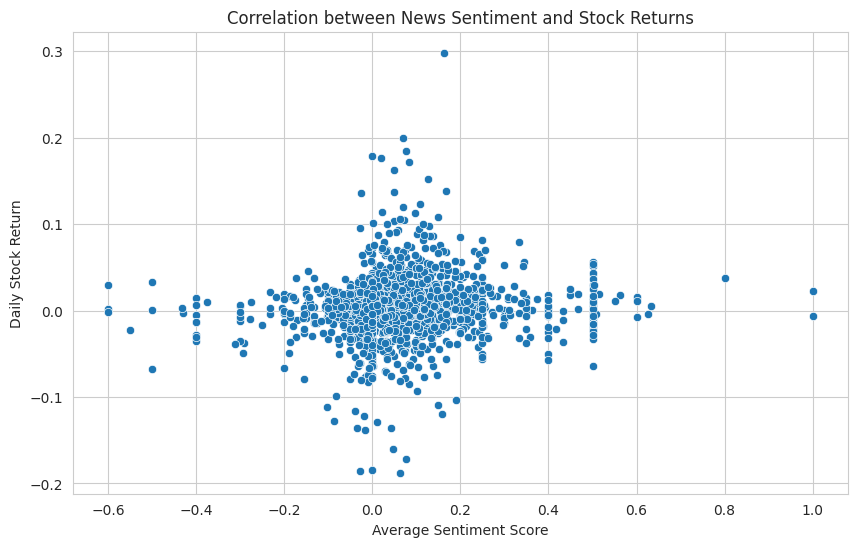

In [50]:
# Plot Sentiment vs Stock Returns
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment_score_textblob', y='Returns', data=final_df)
plt.title('Correlation between News Sentiment and Stock Returns')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Daily Stock Return')
plt.show()

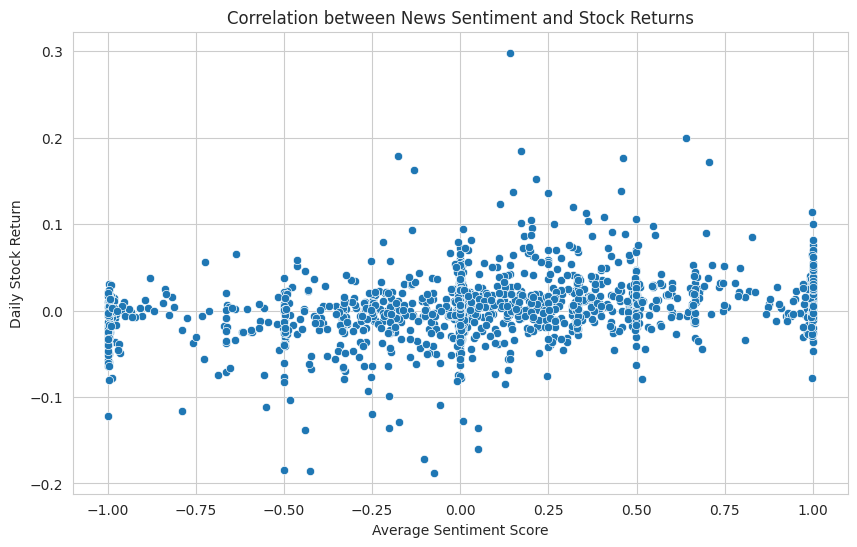

In [55]:
# Plot Sentiment vs Stock Returns
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment_score_roberta', y='Returns', data=final_df)
plt.title('Correlation between News Sentiment and Stock Returns')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Daily Stock Return')
plt.show()